In [13]:
%load_ext autoreload
%autoreload 2
from backend.data import GeoImageDataset, DataLoader, GeoImageIterableDataset
from backend.s3bucket import load_latest_snapshot_df
import torch
import torchvision
import torchvision.transforms.functional as F
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = load_latest_snapshot_df()

In [3]:
df.head()


,batch_date,capture_date,heading,image_path,lat,location_id,lon,pano_id
0,2025-10-16,2025-03,0,s3://cogito-geoguessr/v1/images/location_id=00...,39.336386,00003de7dc43,20.609662,wRauZUaMnO5v9Zw6KRj60Q
1,2025-10-16,2025-03,90,s3://cogito-geoguessr/v1/images/location_id=00...,39.336386,00003de7dc43,20.609662,wRauZUaMnO5v9Zw6KRj60Q
2,2025-10-16,2025-03,180,s3://cogito-geoguessr/v1/images/location_id=00...,39.336386,00003de7dc43,20.609662,wRauZUaMnO5v9Zw6KRj60Q
3,2025-10-16,2025-03,270,s3://cogito-geoguessr/v1/images/location_id=00...,39.336386,00003de7dc43,20.609662,wRauZUaMnO5v9Zw6KRj60Q
4,2025-10-13,2022-07,0,s3://cogito-geoguessr/v1/images/location_id=00...,-35.938561,0000726d0862,146.902454,8P63DvmQqsgA_vHXmDg5wQ


In [4]:
df.describe()


,heading,lat,lon
count,397440.000000,397440.000000,397440.000000
mean,135.000000,26.618552,23.321294
std,100.623186,27.624106,68.230256
min,0.000000,-55.104295,-176.590886
25%,67.500000,9.464303,-4.370105
50%,135.000000,35.487243,19.019108
75%,202.500000,48.543318,78.623948
max,270.000000,81.681056,178.316615


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397440 entries, 0 to 397439
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   batch_date    397440 non-null  object 
 1   capture_date  336388 non-null  object 
 2   heading       397440 non-null  int64  
 3   image_path    397440 non-null  object 
 4   lat           397440 non-null  float64
 5   location_id   397440 non-null  object 
 6   lon           397440 non-null  float64
 7   pano_id       336388 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 24.3+ MB


In [6]:
train_dataset = GeoImageDataset()

2025-10-30 19:27:31.107 | INFO     | backend.data:__init__:9 - loaded snapshot containing 397440 images


Total points saved in S3: 99360
[('out/location_id=00003de7dc43/heading=090.jpg', 'downloaded'), ('out/location_id=00003de7dc43/heading=270.jpg', 'downloaded'), ('out/location_id=00003de7dc43/heading=180.jpg', 'downloaded'), ('out/location_id=00003de7dc43/heading=000.jpg', 'downloaded'), ('out/location_id=0000726d0862/heading=180.jpg', 'downloaded'), ('out/location_id=0000726d0862/heading=000.jpg', 'downloaded'), ('out/location_id=0000726d0862/heading=090.jpg', 'downloaded'), ('out/location_id=0000726d0862/heading=270.jpg', 'downloaded'), ('out/location_id=000102b2049d/heading=090.jpg', 'downloaded'), ('out/location_id=000102b2049d/heading=000.jpg', 'downloaded')]


In [7]:
train_dataset.results

[('out/location_id=00003de7dc43/heading=090.jpg', 'downloaded'),
 ('out/location_id=00003de7dc43/heading=270.jpg', 'downloaded'),
 ('out/location_id=00003de7dc43/heading=180.jpg', 'downloaded'),
 ('out/location_id=00003de7dc43/heading=000.jpg', 'downloaded'),
 ('out/location_id=0000726d0862/heading=180.jpg', 'downloaded'),
 ('out/location_id=0000726d0862/heading=000.jpg', 'downloaded'),
 ('out/location_id=0000726d0862/heading=090.jpg', 'downloaded'),
 ('out/location_id=0000726d0862/heading=270.jpg', 'downloaded'),
 ('out/location_id=000102b2049d/heading=090.jpg', 'downloaded'),
 ('out/location_id=000102b2049d/heading=000.jpg', 'downloaded')]

In [8]:
df = load_latest_snapshot_df().head(10)

# If your df stores full s3:// URIs, bucket can be None.
# If your df stores keys only, set bucket="my-bucket".
dataset = GeoImageIterableDataset(
    df=df,                 # uses load_latest_snapshot_df()
    # You can pass your own torchvision transforms if you need augmentations
    # transform=T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()]),
)
print(f"Dataset size (num samples): {len(dataset)}")
# DataLoader tuned for streaming:
# - iterable dataset + multiple workers for concurrency
# - pin_memory for GPU training
# - persistent_workers to avoid re-inits each epoch
# - prefetch_factor > 2 to keep buffers full
loader = DataLoader(
    dataset,
    batch_size=64,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
    drop_last=False,
    # For IterableDataset, default collate works if each sample returns (Tensor, dict)
)

for batch_idx, (images, targets) in enumerate(loader):
    # images: [B, C, H, W], targets: dict of lists/tensors (collated)
    # Example: Make coords tensor
    lat = torch.tensor([float(x) for x in targets["lat"]], dtype=torch.float32)
    lon = torch.tensor([float(x) for x in targets["lon"]], dtype=torch.float32)
    print(f"Batch {batch_idx}: images.shape={images.shape}, lat.shape={lat.shape}, lon.shape={lon.shape}")
    pass

Dataset size (num samples): 10


/home/sondre/Documents/cogito/geoguessr-ai/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch 0: images.shape=torch.Size([2, 3, 256, 256]), lat.shape=torch.Size([2]), lon.shape=torch.Size([2])
Batch 1: images.shape=torch.Size([2, 3, 256, 256]), lat.shape=torch.Size([2]), lon.shape=torch.Size([2])
Batch 2: images.shape=torch.Size([1, 3, 256, 256]), lat.shape=torch.Size([1]), lon.shape=torch.Size([1])
Batch 3: images.shape=torch.Size([1, 3, 256, 256]), lat.shape=torch.Size([1]), lon.shape=torch.Size([1])
Batch 4: images.shape=torch.Size([1, 3, 256, 256]), lat.shape=torch.Size([1]), lon.shape=torch.Size([1])
Batch 5: images.shape=torch.Size([1, 3, 256, 256]), lat.shape=torch.Size([1]), lon.shape=torch.Size([1])
Batch 6: images.shape=torch.Size([1, 3, 256, 256]), lat.shape=torch.Size([1]), lon.shape=torch.Size([1])
Batch 7: images.shape=torch.Size([1, 3, 256, 256]), lat.shape=torch.Size([1]), lon.shape=torch.Size([1])


Batch 0: images.shape=torch.Size([2, 3, 256, 256]), lat.shape=torch.Size([2]), lon.shape=torch.Size([2])
{'lat': tensor([39.3364, 57.1004], dtype=torch.float64), 'lon': tensor([20.6097, 26.2800], dtype=torch.float64), 'heading': tensor([0, 0]), 'location_id': ['00003de7dc43', '000102b2049d'], 'pano_id': ['wRauZUaMnO5v9Zw6KRj60Q', 'LjUG8Sk4jlrSw3cbBsoKfA'], 'capture_date': ['2025-03', '2011-08'], 'batch_date': ['2025-10-16', '2025-10-19'], 'image_path': ['s3://cogito-geoguessr/v1/images/location_id=00003de7dc43/heading=000.jpg', 's3://cogito-geoguessr/v1/images/location_id=000102b2049d/heading=000.jpg']}


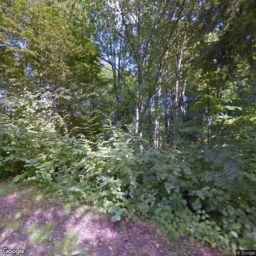

In [ ]:
for batch_idx, (images, targets) in enumerate(loader):
    # images: [B, C, H, W], targets: dict of lists/tensors (collated)
    # Example: Make coords tensor
    lat = torch.tensor([float(x) for x in targets["lat"]], dtype=torch.float32)
    lon = torch.tensor([float(x) for x in targets["lon"]], dtype=torch.float32)
    print(f"Batch {batch_idx}: images.shape={images.shape}, lat.shape={lat.shape}, lon.shape={lon.shape}")
    print(targets)

    # Visualize one image from the batch (targets is a dict, not an image)
    pil_img = F.to_pil_image(images[0].cpu())  # first sample in batch
    display(pil_img)

    # Alternatively, visualize a grid of the first 16 images:
    grid = torchvision.utils.make_grid(images[:16].cpu(), nrow=8, normalize=True)
    display(F.to_pil_image(grid))

    break